In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

sys.path.append("..")
import utils

In [2]:
# load data
qbo_raw = utils.get_qbo()

# deseasonalize
qbo_anom = qbo_raw.groupby("time.dayofyear") - qbo_raw.groupby("time.dayofyear").mean()
qbo = qbo_anom.drop("dayofyear")

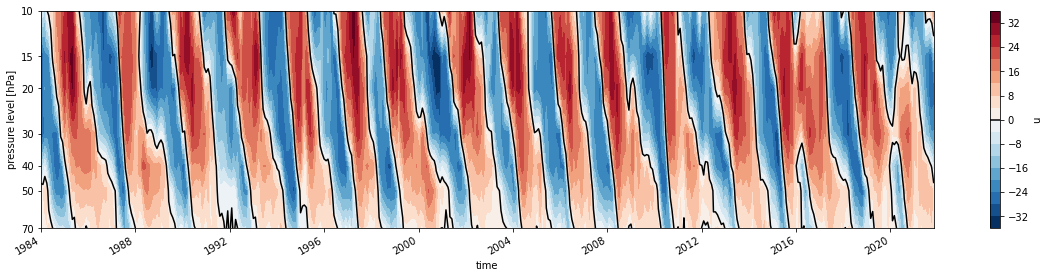

In [3]:
fig, ax = plt.subplots(figsize=(20, 4))
res = qbo.plot.contourf(levels=20, yincrease=False, ax=ax)
res.colorbar.ax.axhline(0, color="k")
qbo.plot.contour(levels=[0], yincrease=False, ax=ax, colors="k")
ax.set_yscale("log")
ax.set_yticks(qbo.p.values)
ax.minorticks_off()
ax.yaxis.set_major_formatter(plt.ScalarFormatter())
plt.show()

In [4]:
from eofs.xarray import Eof

ModuleNotFoundError: No module named 'eofs'

In [5]:
solver = Eof(qbo.T)

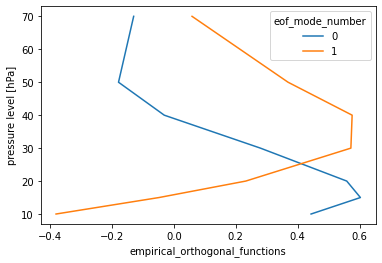

In [6]:
eofs = solver.eofs(neofs=2)

eofs.plot(hue="mode", y="p")
plt.show()

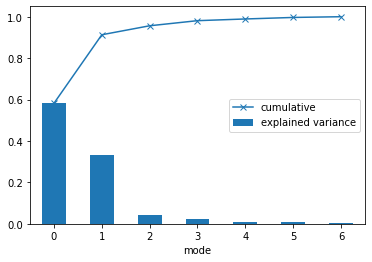

In [7]:
var_expl = solver.varianceFraction()
var_expl.to_series().plot.bar(label="explained variance")
np.cumsum(var_expl).to_series().plot(marker="x", label="cumulative")
plt.legend(loc="center right")
plt.show()

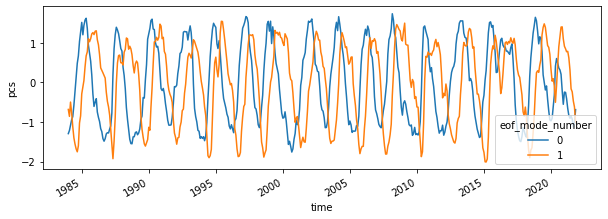

In [8]:
pcs = solver.pcs(npcs=2, pcscaling=1)

pcs.isel(mode=range(2)).plot(hue="mode", figsize=(10, 3))
plt.show()

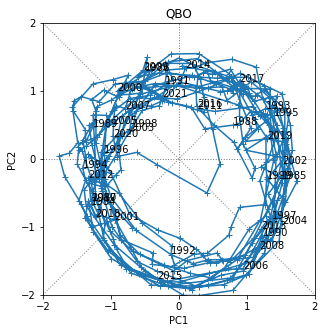

In [9]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(pcs.sel(mode=0), pcs.sel(mode=1), marker="+")
for key, value in pcs.groupby("time.year"):
    one_timestep = pcs.sel(time=str(key)).isel(time=0)
    ax.text(
        float(one_timestep.sel(mode=0).values),
        float(one_timestep.sel(mode=1).values),
        f"{one_timestep.time.dt.year.values}",
    )
ax.set_aspect("equal")
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(1))
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("QBO")

line_kwargs = dict(ls=":", zorder=-5, color="gray", lw=1)
ax.plot([-2, 2], [-2, 2], **line_kwargs)
ax.plot([-2, 2], [2, -2], **line_kwargs)
ax.axhline(0, **line_kwargs)
ax.axvline(0, **line_kwargs)

ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

plt.show()

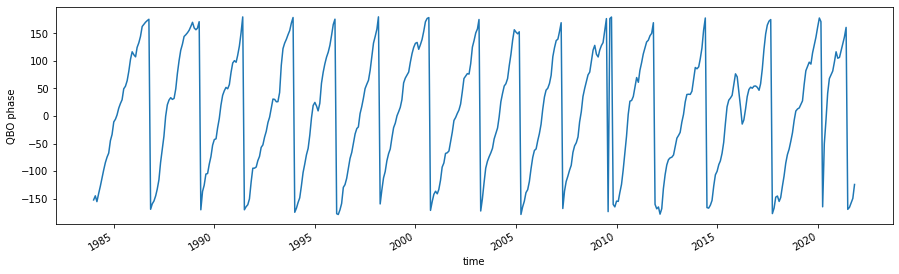

In [10]:
qbo_phase = np.rad2deg((np.arctan2(pcs.sel(mode=1), pcs.sel(mode=0)))).rename(
    "QBO phase"
)
qbo_phase.plot(figsize=(15, 4))
plt.show()

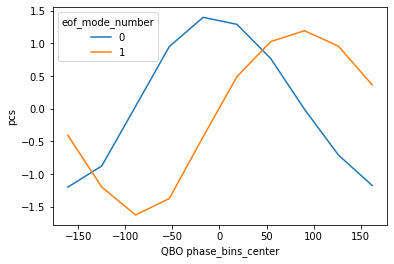

In [11]:
pcs.groupby_bins(qbo_phase, bins=10).mean().plot(hue="mode")
plt.show()

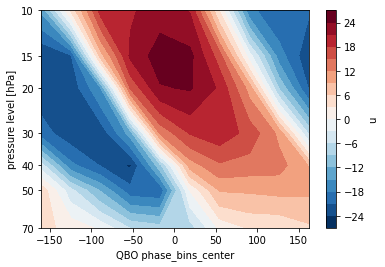

In [12]:
fig, ax = plt.subplots()
qbo.groupby_bins(qbo_phase, bins=10).mean().plot.contourf(
    yincrease=False, levels=20, yscale="log", ax=ax
)
ax.set_yticks(qbo.p.values)
ax.minorticks_off()
ax.yaxis.set_major_formatter(plt.ScalarFormatter())
plt.show()

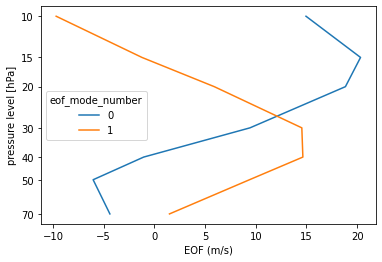

In [13]:
fig, ax = plt.subplots()
xr.cov(qbo, pcs, dim="time").plot(yincrease=False, yscale="log", y="p", hue='mode', ax=ax)
ax.set_xlabel("EOF (m/s)")
ax.set_yticks(qbo.p.values)
ax.minorticks_off()
ax.yaxis.set_major_formatter(plt.ScalarFormatter())
plt.show()